<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/banner_IA.png"  width="1000px" height="250px">


#  <center> **05. Classification - Metrics** </center>





In [1]:
#@title **MOUNT DRIVE** { display-mode: "form" }
import os
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data**


In [2]:
#@title **Import libraries**
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import torch 

In [3]:
dataset_path = "/content/drive/MyDrive/Maestría/Semillero/dataset/Train/"
polyp_path = "/content/drive/MyDrive/Maestría/Semillero/dataset/Train/Polyp/"
non_polyp_path = "/content/drive/MyDrive/Maestría/Semillero/dataset/Train/Non-Polyp/"

#Now, we're gonna use a library called os.
import os

polyp_imgs = os.listdir(polyp_path)
non_polyp_imgs = os.listdir(non_polyp_path)

print("Quantity of polyps:     ", len(polyp_imgs), polyp_imgs)
print("Quantity of non-polyps: ", len(non_polyp_imgs), non_polyp_imgs)  


Quantity of polyps:      800 ['1 (669).jpg', '1 (686).jpg', '1 (678).jpg', '1 (672).jpg', '1 (658).jpg', '1 (661).jpg', '1 (656).jpg', '1 (676).jpg', '1 (652).jpg', '1 (651).jpg', '1 (736).jpg', '1 (735).jpg', '1 (689).jpg', '1 (691).jpg', '1 (709).jpg', '1 (711).jpg', '1 (707).jpg', '1 (703).jpg', '1 (704).jpg', '1 (697).jpg', '1 (775).jpg', '1 (750).jpg', '1 (795).jpg', '1 (794).jpg', '1 (793).jpg', '1 (47).jpg', '1 (58).jpg', '1 (83).jpg', '1 (57).jpg', '1 (7).jpg', '1 (27).jpg', '1 (28).jpg', '1 (92).jpg', '1 (93).jpg', '1 (73).jpg', '1 (74).jpg', '1 (81).jpg', '1 (130).jpg', '1 (172).jpg', '1 (173).jpg', '1 (175).jpg', '1 (168).jpg', '1 (117).jpg', '1 (115).jpg', '1 (99).jpg', '1 (100).jpg', '1 (98).jpg', '1 (176).jpg', '1 (200).jpg', '1 (201).jpg', '1 (154).jpg', '1 (155).jpg', '1 (156).jpg', '1 (103).jpg', '1 (106).jpg', '1 (141).jpg', '1 (142).jpg', '1 (252).jpg', '1 (255).jpg', '1 (297).jpg', '1 (216).jpg', '1 (290).jpg', '1 (291).jpg', '1 (228).jpg', '1 (227).jpg', '1 (235).j

Now, we need to otain an array of its position and class

In [5]:
polyp_complete_path = []; non_polyp_complete_path = []; polyp_class = []; non_polyp_class = []
# print("------------------------  Polyps  ------------------------ ")
for index, data in enumerate(polyp_imgs):
  # print("\nData: ", data)  #Each polyp image
  path_img = os.path.join(polyp_path, data)
  # print("Path of the image: ", path_img)
  polyp_complete_path.append(path_img) 
  polyp_class.append(1)

# print("\n------------------------ Non-Polyps ------------------------ ")
for index, data in enumerate(non_polyp_imgs):
  # print("\nData: ", data)  #Each Non-polyp image
  path_img = os.path.join(non_polyp_path, data)
  # print("Path of the image: ", path_img)
  non_polyp_complete_path.append(path_img)
  non_polyp_class.append(0)

After the vectors were obtained, it is necessary to create a dataframe

In [6]:
import pandas as pd

polyps_dt = pd.DataFrame({
    'image_path': np.concatenate((polyp_complete_path, non_polyp_complete_path)),
    'class': np.concatenate((polyp_class, non_polyp_class))
})

polyps_dataset = polyps_dt[:]
polyps_dataset

image_path  class
0     /content/drive/MyDrive/Maestría/Semillero/data...      1
1     /content/drive/MyDrive/Maestría/Semillero/data...      1
2     /content/drive/MyDrive/Maestría/Semillero/data...      1
3     /content/drive/MyDrive/Maestría/Semillero/data...      1
4     /content/drive/MyDrive/Maestría/Semillero/data...      1
...                                                 ...    ...
6995  /content/drive/MyDrive/Maestría/Semillero/data...      0
6996  /content/drive/MyDrive/Maestría/Semillero/data...      0
6997  /content/drive/MyDrive/Maestría/Semillero/data...      0
6998  /content/drive/MyDrive/Maestría/Semillero/data...      0
6999  /content/drive/MyDrive/Maestría/Semillero/data...      0

[7000 rows x 2 columns]

In [7]:
polyps_dataset["class"].value_counts()

0    6200
1     800
Name: class, dtype: int64

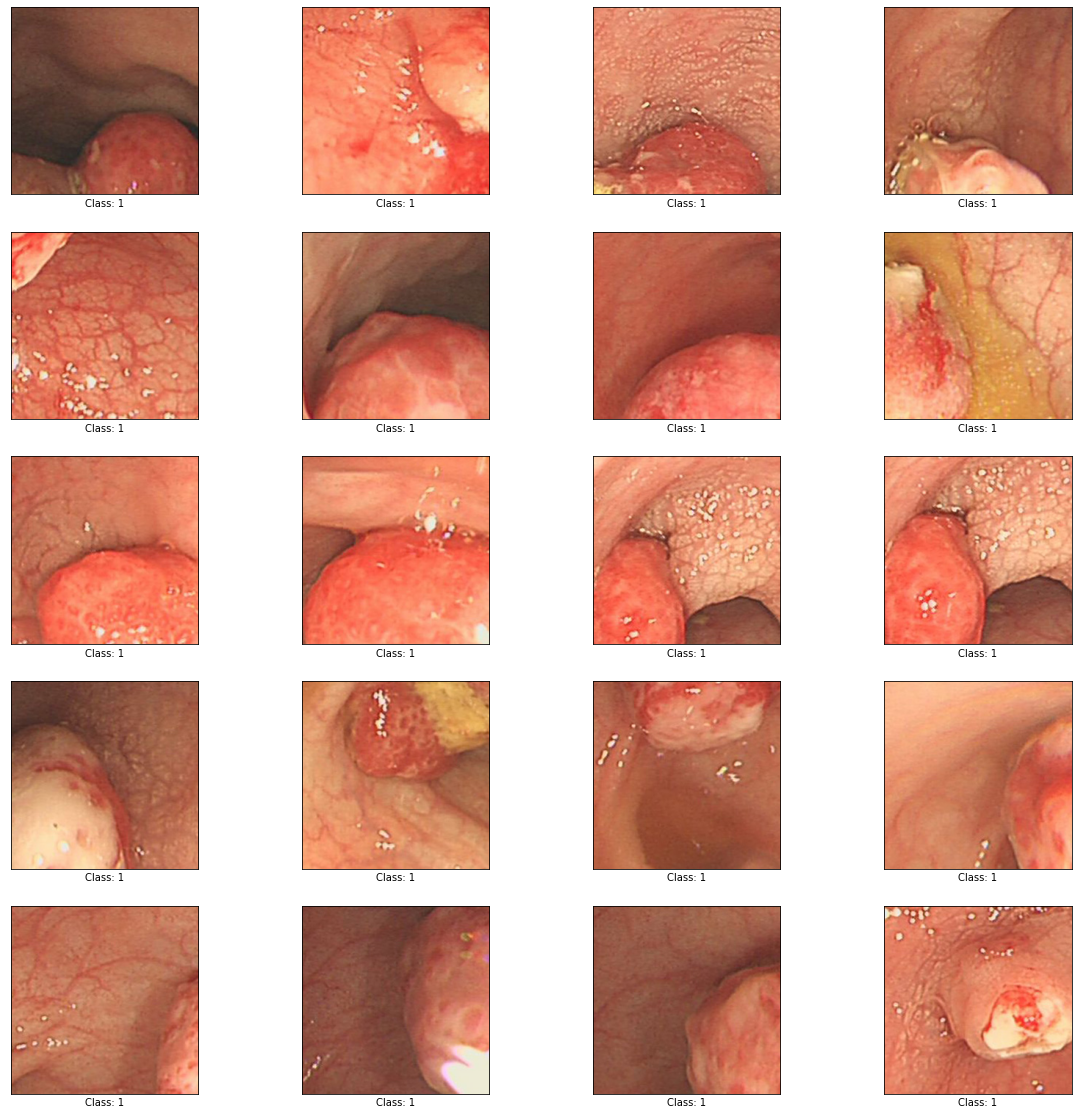

In [8]:
plt.figure(figsize=(20,20))
for index_plot in range(20):
  plt.subplot(5, 4, index_plot+1)
  plt.xticks([]); plt.yticks([])
  img = imageio.imread(polyps_dataset['image_path'][index_plot])
  plt.imshow(img)
  plt.xlabel("Class: {}".format(polyps_dataset['class'][index_plot]))

# **Data Generator**

In [9]:
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image

In [10]:
class PolypData(data.Dataset):
    def __init__(self, image_path, label, trainsize):
   
        self.images_root = image_path
        self.label = label
        self.trainsize = trainsize

        self.img_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.images_root)

    def __getitem__(self, index):
        image = self.rgb_loader(self.images_root[index])
        image = self.img_transform(image)

        name = self.images_root[index].split('-')[0]
        
        label = self.label[index]
        
        return image, label

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

def get_loader(image_path, label, batchsize, trainsize, shuffle=True, num_workers=2, pin_memory=True):
    dataset = PolypData(image_path, label, trainsize)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader

In [11]:
train_loader = get_loader(polyps_dataset["image_path"].values, polyps_dataset["class"].values, batchsize=8, trainsize=32)

## **Test**

In [12]:
dataset_path = "/content/drive/MyDrive/Maestría/Semillero/dataset/Test/"
polyp_path = "/content/drive/MyDrive/Maestría/Semillero/dataset/Test/Polyp/"
non_polyp_path = "/content/drive/MyDrive/Maestría/Semillero/dataset/Test/Non-Polyp/"

polyp_imgs = os.listdir(polyp_path)
non_polyp_imgs = os.listdir(non_polyp_path)

print("Quantity of polyps:     ", len(polyp_imgs), polyp_imgs)
print("Quantity of non-polyps: ", len(non_polyp_imgs), non_polyp_imgs)  

polyp_complete_path = []; non_polyp_complete_path = []; polyp_class = []; non_polyp_class = []
# print("------------------------  Polyps  ------------------------ ")
for index, data in enumerate(polyp_imgs):
  path_img = os.path.join(polyp_path, data)
  polyp_complete_path.append(path_img) 
  polyp_class.append(1)

# print("\n------------------------ Non-Polyps ------------------------ ")
for index, data in enumerate(non_polyp_imgs):
  path_img = os.path.join(non_polyp_path, data)
  non_polyp_complete_path.append(path_img)
  non_polyp_class.append(0)

Quantity of polyps:      200 ['1 (2).jpg', '1 (1).jpg', '1 (3).jpg', '1 (30).jpg', '1 (23).jpg', '1 (26).jpg', '1 (24).jpg', '1 (7).jpg', '1 (6).jpg', '1 (15).jpg', '1 (20).jpg', '1 (18).jpg', '1 (22).jpg', '1 (48).jpg', '1 (44).jpg', '1 (41).jpg', '1 (43).jpg', '1 (40).jpg', '1 (39).jpg', '1 (91).jpg', '1 (89).jpg', '1 (98).jpg', '1 (94).jpg', '1 (35).jpg', '1 (61).jpg', '1 (109).jpg', '1 (136).jpg', '1 (139).jpg', '1 (132).jpg', '1 (125).jpg', '1 (123).jpg', '1 (120).jpg', '1 (103).jpg', '1 (129).jpg', '1 (130).jpg', '1 (198).jpg', '1 (169).jpg', '1 (168).jpg', '1 (154).jpg', '1 (156).jpg', '1 (191).jpg', '1 (190).jpg', '1 (185).jpg', '1 (178).jpg', '1 (182).jpg', '1 (180).jpg', '1 (194).jpg', '1 (187).jpg', '1 (29).jpg', '1 (31).jpg', '1 (27).jpg', '1 (10).jpg', '1 (9).jpg', '1 (12).jpg', '1 (14).jpg', '1 (45).jpg', '1 (56).jpg', '1 (55).jpg', '1 (101).jpg', '1 (74).jpg', '1 (68).jpg', '1 (76).jpg', '1 (73).jpg', '1 (70).jpg', '1 (72).jpg', '1 (71).jpg', '1 (93).jpg', '1 (62).jpg', 

In [13]:
import pandas as pd

polyps_dt_test = pd.DataFrame({
    'image_path': np.concatenate((polyp_complete_path, non_polyp_complete_path)),
    'class': np.concatenate((polyp_class, non_polyp_class))
})
polyps_dataset_test = pd.concat([polyps_dt_test[:100], polyps_dt_test[900:]])
polyps_dataset_test

image_path  class
0    /content/drive/MyDrive/Maestría/Semillero/data...      1
1    /content/drive/MyDrive/Maestría/Semillero/data...      1
2    /content/drive/MyDrive/Maestría/Semillero/data...      1
3    /content/drive/MyDrive/Maestría/Semillero/data...      1
4    /content/drive/MyDrive/Maestría/Semillero/data...      1
..                                                 ...    ...
995  /content/drive/MyDrive/Maestría/Semillero/data...      0
996  /content/drive/MyDrive/Maestría/Semillero/data...      0
997  /content/drive/MyDrive/Maestría/Semillero/data...      0
998  /content/drive/MyDrive/Maestría/Semillero/data...      0
999  /content/drive/MyDrive/Maestría/Semillero/data...      0

[200 rows x 2 columns]

In [14]:
polyps_dataset_test["class"].value_counts()

1    100
0    100
Name: class, dtype: int64

In [15]:
class test_dataset:
    def __init__(self, image_path, label, testsize):
        self.testsize = testsize
        self.images = sorted(image_path)
        self.label = sorted(label)
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.rgb_loader(self.images[self.index])
        image = self.transform(image).unsqueeze(0)
        label = self.label[self.index]
        self.index += 1
        return image, label

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

#**How to load a pretrained model**

In [16]:
import torch.nn             as nn
import torch.nn.functional  as F
from torchvision.models.vgg import vgg16

In [17]:
vgg_model = vgg16(pretrained=True)
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
class vgg_changed_net(nn.Module):
  def __init__(self):
        super().__init__()
        self.vgg_model = vgg16(pretrained=True)
        # self.vgg_model = nn.Sequential(*(list(self.vgg_model.children())[:-1])) 
        self.classification = nn.Sequential(
             nn.ReLU(inplace=True),
             nn.Dropout(p=0.5, inplace=False),
             nn.Linear(in_features=1000, out_features=1, bias=True),
         )
  
  def forward(self, x):
    x = self.vgg_model(x)
    x = self.classification(x)
    
    return x
  
net = vgg_changed_net()
params = list(net.parameters())
print(len(params))
print(params[0].size())

34
torch.Size([64, 3, 3, 3])


In [19]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [20]:
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
  
    for batch, (X, y) in enumerate(dataloader):
        X, y = X, y

        # Compute prediction error
        pred = model(X)
        pred = torch.sigmoid(pred.squeeze(1))
        y = y.type(torch.FloatTensor)
        loss = F.binary_cross_entropy_with_logits(pred, y, reduce='none')
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return model

In [21]:
def test(dataloader, model):
    size = dataloader.size
    model.eval()
    correct = 0
    y_total, pred_total = [], []
    with torch.no_grad():
        for i in range(test_loader.size):
            X, y = dataloader.load_data()
            pred = model(X)
            pred = torch.round(torch.sigmoid(pred.squeeze(1)))
            y_total.append(y)
            pred_total.append(pred)
            correct += (pred == y).type(torch.float).sum().item()

    correct /= size
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%\n")

    return y_total, pred_total

In [ ]:
epochs = 5
test_loader = test_dataset(polyps_dataset_test["image_path"].values, polyps_dataset_test["class"].values, testsize = 352)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model = train(train_loader, net, optimizer)
    torch.save(model.state_dict(), 'model' + str(t) + '.pth')
    test_loader = test_dataset(polyps_dataset_test["image_path"].values, polyps_dataset_test["class"].values, testsize = 352)

    y, p = test(test_loader, net)
    print(y)
    print(p)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss: 0.693147  [    0/ 7000]
loss: 0.693147  [  800/ 7000]
loss: 0.693147  [ 1600/ 7000]
loss: 0.693147  [ 2400/ 7000]
loss: 0.693147  [ 3200/ 7000]
loss: 0.693147  [ 4000/ 7000]
loss: 0.693147  [ 4800/ 7000]
loss: 0.693147  [ 5600/ 7000]
loss: 0.693147  [ 6400/ 7000]
Test: 
 Accuracy: 50.0%

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tenso

In [105]:
# Cargar un modelo
test_loader = test_dataset(polyps_dataset_test["image_path"].values, polyps_dataset_test["class"].values, testsize = 352)

model = vgg_changed_net()
model.load_state_dict(torch.load('/content/model.pth'))
y, p = test(test_loader, model)

Test: 
 Accuracy: 52.0%



In [110]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
print('Accuracy:', accuracy_score(y, p))
print('F1 score:', f1_score(y, p))
print('Recall:', recall_score(y, p))
print('Precision:', precision_score(y, p))
print('\n clasification report:\n', classification_report(y,p))
print('\n confussion matrix:\n',confusion_matrix(y, p))

Accuracy: 0.52
F1 score: 0.07692307692307693
Recall: 0.04
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68        50
           1       1.00      0.04      0.08        50

    accuracy                           0.52       100
   macro avg       0.76      0.52      0.38       100
weighted avg       0.76      0.52      0.38       100


 confussion matrix:
 [[50  0]
 [48  2]]


---
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/bannerThanks.jpg" alt="Drawing" style="width:700px;">